# FRUIT INSPECTION
## Task 2: Russets detection

mages in folder “second task” show two apples with an unwanted reddish-brown area. Students should identify the russet or at least some part of it with no false positive areas (if possible), in order to correctly
classify the two fruits.

### Library import and initial setup
In this section we import the necessaries libraries and retrive the images from google drive. Then we unzip the folder and start working

In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [ ]:
! gdown --id 12vNN-PcvycfyN8TMREQStGl_9Rx_Ivm5

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=12vNN-PcvycfyN8TMREQStGl_9Rx_Ivm5
To: /content/images.zip
100% 1.01M/1.01M [00:00<00:00, 109MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile("/content/images.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

Taken the folder, images are loaded in alphabetical order (sorted) and it is checked in the title if it is present:
* "C1" for color images, placed in color_images
* "C0" for black and white images, placed in gray_images

An image will have the same index in the gray or colored list (e.g. the corresponding grey image of color_images[0] will be in grey_images[0])

Then we print them out so we can show them and start working on them

In [ ]:
import os
# assign directory
directory = '/content/images/task2/'
 
# iterate over files in
# that directory
grey_images = []
color_images = []
for filename in sorted(os.listdir(directory)):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
      # if C1 then is colored image
      if "/content/images/task2/C1" in f:
        img = cv.imread(f)
        color_images.append(img)
      # if C0 then is gray image
      elif "/content/images/task2/C0" in f:
        img = cv.imread(f, cv.IMREAD_GRAYSCALE)
        grey_images.append(img)

Let's write an utility function that allows us to plot several images one near to another one using matplotlib

In [ ]:
def plot_images(images, cmap=None, title='', custom_title=None, axis='off', size=None, figsize=(10, 5)):

  n_images = len(images)
  
  if not custom_title:
    custom_title = range(1, len(images)+1)
  
  fig, axes = plt.subplots(1, n_images, figsize=figsize)
  
  for i in range(len(images)):
    axes[i].axis(axis)
    axes[i].set_title(title + " {}".format(custom_title[i]), size=size)
    axes[i].imshow(images[i], cmap=cmap)
  
  plt.show()

### filled mask extraction

Testing of the function by plotting the grayscale images

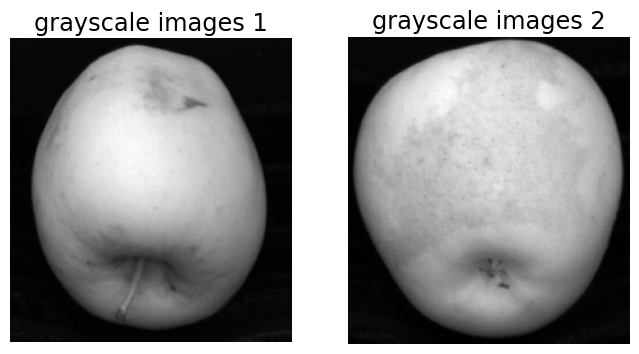

In [ ]:
plot_images(grey_images, size="xx-large", cmap='gray', title="grayscale images", figsize=(8, 4))

mask detection by Otsu threshold

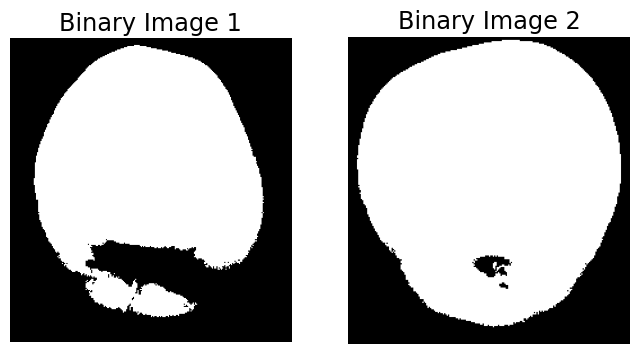

In [ ]:
binary_masks = []

# Threshold the image to segment the apple from the background
# the output of the threshold function is a tuple: the first element is the threshold value,
# the second is the image itself
binary_masks.append(cv.threshold(grey_images[0], 0, 255, cv.THRESH_OTSU)[1])
binary_masks.append(cv.threshold(grey_images[1], 0, 255, cv.THRESH_OTSU)[1])

plot_images(binary_masks, size="xx-large", cmap='gray', title="Binary Image", figsize=(8, 4))

writing of a function that, taken as input a binary image, fills the internal holes and remap everything to the range 0, 1

In [ ]:
def fill_holes(img):
    blur = cv.GaussianBlur(img,(5,5),0)

    # Threshold the grayscale image to create a binary mask
    ret, mask = cv.threshold(blur, 75, 1, cv.THRESH_BINARY)

    # Perform the floodfill operation to fill holes
    h, w = mask.shape[:2]
    mask_filled = np.zeros((h + 2, w + 2), np.uint8)
    cv.floodFill(mask, mask_filled, (0, 0), 255)
    mask = cv.bitwise_not(mask)

    # after a careful analysis of the pixels of the mask, all of them have a 
    # value of 0 (background region), 255 (foreground region), but some of them 
    # have a value of 255. For the sake of correctness, we replace these pixels 
    # with the value 255, and then all the 255 pixel are converted to 1.
    mask[mask == 254] = 255
    mask[mask == 255] = 1
    
    # Return the filled image
    return mask

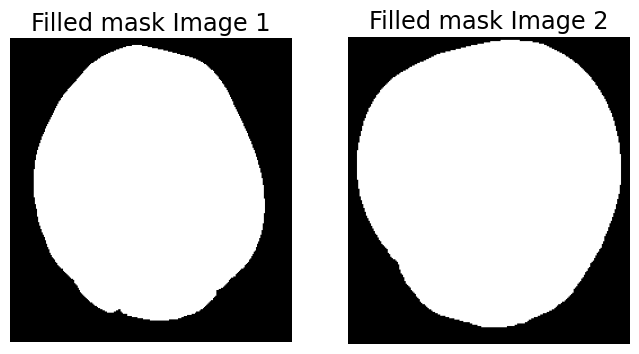

In [ ]:
for i in range(len(grey_images)):
  binary_masks[i] = fill_holes(grey_images[i])

plot_images(binary_masks, size="xx-large", cmap='gray', title="Filled mask Image", figsize=(8, 4))

### Mahalanobis distance

As we can see, we need to apply a color segmentation. We chose to apply the Mahalanobis distance. Now, we try to consider several color spaces in order to understand if there is a specific space in which the russets are more highlited

In [ ]:
color_spaces = {"RGB": cv.COLOR_BGR2RGB,
                "HSV": cv.COLOR_BGR2HSV,
                "HLS": cv.COLOR_BGR2HLS,
                "LUV": cv.COLOR_BGR2Luv}

edited_colored_images = {0: color_images[0], 1: color_images[1]}

all_images = []

for index, image in edited_colored_images.items():
  converted_images = [cv.cvtColor(image, single_color_space) for single_color_space in color_spaces.values()]

  all_images.append(converted_images)

Now, the varible all_images is a list of 2 lists, where each one represents the RGB, HSV, HLS and LUV color spaces of the first and the second image respectively.

  - RGB (Red-Green-Blue).

  - HSV (Hue-Saturation-Value).

  - HLS (Hue-Lightness-Saturation).

  - LUV (Lightness-Colorfulness-Saturation).

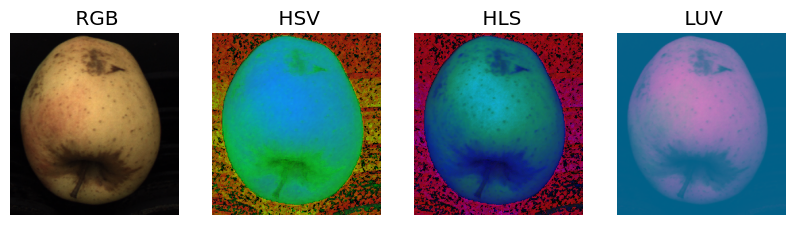

In [ ]:
plot_images(all_images[0], size="x-large", custom_title=list(color_spaces.keys()))

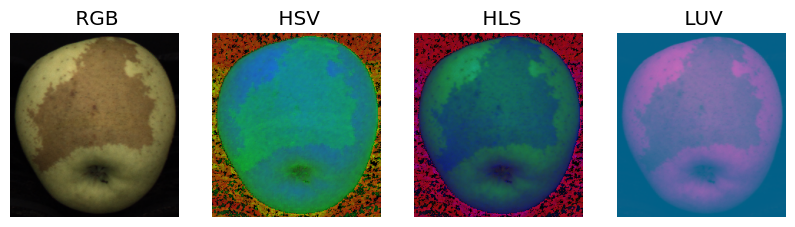

In [ ]:
plot_images(all_images[1], size="x-large", custom_title=list(color_spaces.keys()))

As we can see, in HSV, HLS and LUV color spaces the background is not black, so we apply the filled mask represented before in order to set at (0, 0, 0) the color channels of the background pixels in every image

In [ ]:
for i, images in enumerate(all_images):
  for j in range(len(images)):
    #apply mask
    for k in range(images[j].shape[2]):
      images[j][:,:,k] *= binary_masks[i]

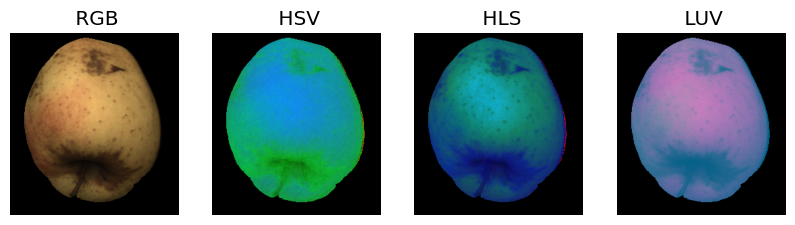

In [ ]:
plot_images(all_images[0], size="x-large", custom_title=list(color_spaces.keys()))

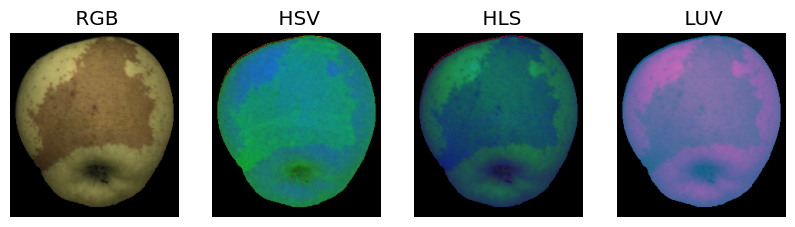

In [ ]:
plot_images(all_images[1], size="x-large", custom_title=list(color_spaces.keys()))

As we noticed, there is a clear visible contrast only in two color spaces out of four: RGB and HLS. So, let's compute the Mahalanobis distance only in those spaces.

In [ ]:
# HSV and LUV removal image 1
del all_images [0][3]
del all_images [0][1]

# HSV and LUV removal image 2
del all_images [1][3]
del all_images [1][1]

# remove from the dictionary the color spaces ignored, for a correct printing later
del color_spaces['HSV']
del color_spaces['LUV']

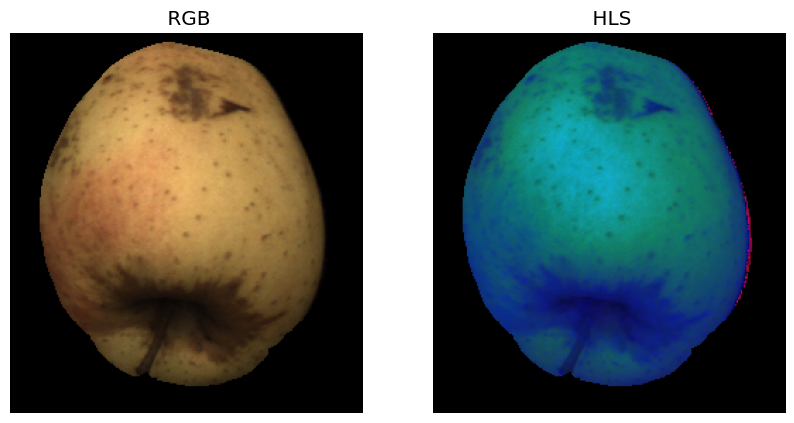

In [ ]:
plot_images(all_images[0], size="x-large", custom_title=list(color_spaces.keys()))

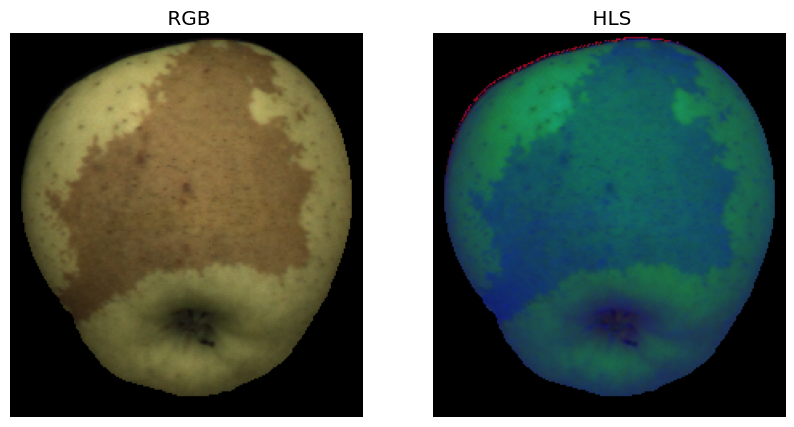

In [ ]:
plot_images(all_images[1], size="x-large", custom_title=list(color_spaces.keys()))

### Samples selection and extraction

In [ ]:
# Select the training images
training_images = []

for image in all_images[1]:
  training_images.append(np.copy(image))

Enhancing of three subimages extracted as training set

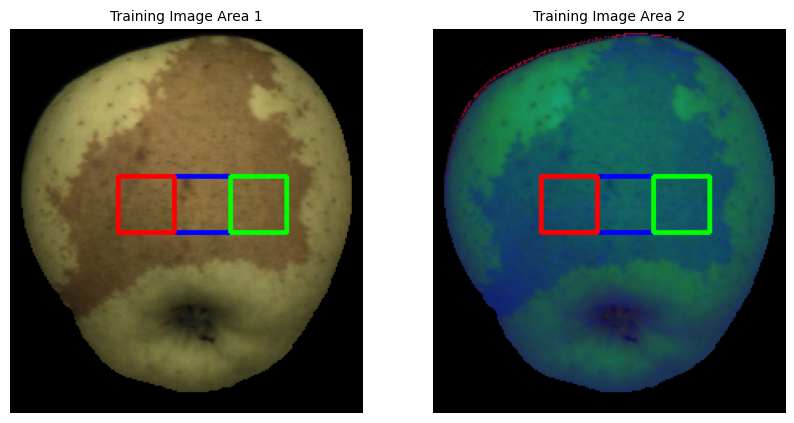

In [ ]:
rec_images = []

m, n, _ = training_images[0].shape
window_size = 35

# first 35x35 sample
start_point_1 = ((m-window_size)//2, (n-window_size)//2)
end_point_1 = ((m+window_size)//2, (n+window_size)//2)

# Second 35x35 sample
start_point_2 = (start_point_1[0] - window_size, start_point_1[1] + window_size)
end_point_2 = (end_point_1[0] - window_size, end_point_1[1] - window_size)

# Third 35x35 sample
start_point_3 = (start_point_1[0] + window_size, start_point_1[1] + window_size)
end_point_3 = (end_point_1[0] + window_size, end_point_1[1] - window_size)

for training_image in training_images:
  image = cv.rectangle(training_image, start_point_1, end_point_1, (0, 0, 255), 2)
  image = cv.rectangle(training_image, start_point_2, end_point_2, (255, 0, 0), 2)
  image = cv.rectangle(training_image, start_point_3, end_point_3, (0, 255, 0), 2)

  rec_images.append(image)

plot_images(rec_images, title="Training Image Area")

So, arrived at this point, we extracted the three subimages per color image to use as training set:

In [ ]:
# list of all start points
start_points = [start_point_1, start_point_2, start_point_3]

# list of all end points
end_points = [end_point_1, end_point_2, end_point_3]

subimages extraction

In [ ]:
def extract_subimage(img, start_point, end_point):
  
  # list conversion for allowing the swap operation 
  start_point = list(start_point)
  end_point = list(end_point)

  # Swap the start and end points if necessary
  if end_point[0] < start_point[0]:
      start_point[0], end_point[0] = end_point[0], start_point[0]
  if end_point[1] < start_point[1]:
      start_point[1], end_point[1] = end_point[1], start_point[1]

  # Extract the sub-image using numpy slicing
  subimg = img[start_point[1]:end_point[1], start_point[0]:end_point[0]]
  return subimg

# list of the two elements, RGB and HLS. Each of them represents a three-sublist sample relaed to that color space
all_window_training = []

for i, image in enumerate(all_images[1]):

  image_windows = []
  for startP, endP in zip(start_points, end_points):
    img = extract_subimage(image, startP, endP)
    image_windows.append(img)
  all_window_training.append(image_windows)

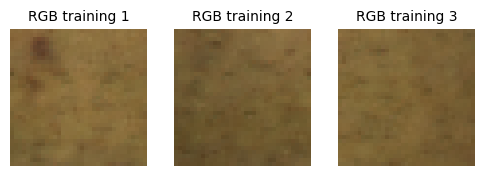

In [ ]:
plot_images(all_window_training[0], title="RGB training", figsize=(6, 6))

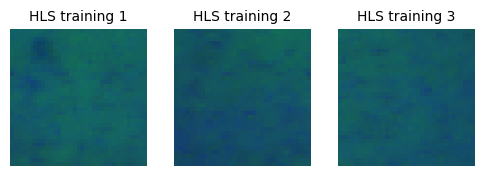

In [ ]:
plot_images(all_window_training[1], title="HLS training", figsize=(6, 6))

computation of the means and the inverse covariance matrixes for both the color spaces on the three images selected per color space).

In [ ]:
RGB_HLS_mean_icovs = []

for index in range(len(all_window_training)):

  final_mean = np.zeros((1, 3), dtype="float64")
  final_cov = np.zeros((3, 3), dtype="float64")

  for img in all_window_training[index]:

    # Reshaping the 2D matrix of A and B color values 
    # into a 1D matrix by using the reshape() method. The resulting sampleAB 
    # matrix will have a shape of (number of pixels in sample, 3) where each 
    # row contains the A and B color values of a single pixel.
    img = img.reshape(img.shape[0] * img.shape[1], 3)

    # The cv.calcCovarMatrix() function from OpenCV takes the following parameters:

    #   - sampleAB: The input dataset. It should be a 2D numpy array where each 
    #               row represents a sample, and each column represents a feature.
    #
    #   - weights: optional input array of weights, which is used to compute a 
    #              weighted covariance matrix instead of a regular covariance 
    #              matrix. We set it to None.
    #
    #   - flags: A combination of flag values that control the behavior of the 
    #            function. In this case, the flags are cv.COVAR_NORMAL, 
    #            cv.COVAR_ROWS, and cv.COVAR_SCALE.
    #
    #    - mean: An optional output parameter that stores the mean vector of 
    #            the input data.
    #    
    #    - dtype: An optional data type of the output covariance matrix. 
    #             If not provided, it defaults to numpy.float64.

    cov, mean = cv.calcCovarMatrix(img, None, cv.COVAR_NORMAL | cv.COVAR_ROWS | cv.COVAR_SCALE)
    final_cov += cov
    final_mean += mean
  
  # mean and inverted covariance matrix of the RGB samples
  final_mean = final_mean/len(all_window_training[index])
  icov = cv.invert(final_cov, cv.DECOMP_SVD)

  RGB_HLS_mean_icovs.append((final_mean, icov[1]))

RGB_HLS_mean_icovs now contains two tuples:
  - the first tuple is related to RGB channel: the first element is the mean, the second is inverted covariance matrix.

  - the second tuple is related to HLS channel: the first element is the mean, the second is inverted covariance matrix.

Mahalanobis distance computation for the RGB color space

In [ ]:
# RGB distances computation
RGB_distances = []
for image in color_images:
  distance=np.zeros((image.shape[0], image.shape[1]))
  image= cv.cvtColor(image, cv.COLOR_BGR2RGB)
  for i in range(image.shape[0]):
      for j in range(image.shape[1]):
          px = np.array(image[i][j]).reshape(1, 3)
          distance[i][j] = cdist(px, RGB_HLS_mean_icovs[0][0], 'mahalanobis', VI=RGB_HLS_mean_icovs[0][1])

  # matrix of distances normalized and multiplied by 255, so the new range of 
  # distances is between 0 and 255
  distance = np.divide(distance, np.max(distance)) * 255
  RGB_distances.append(distance)

Mahalanobis distance computation for the HLS color space

In [ ]:
# HLS distances computation
HLS_distances = []
for image in color_images:
  distance=np.zeros((image.shape[0], image.shape[1]))
  image= cv.cvtColor(image, cv.COLOR_BGR2HLS)
  for i in range(image.shape[0]):
      for j in range(image.shape[1]):
          px = np.array(image[i][j]).reshape(1, 3)
          distance[i][j] = cdist(px, RGB_HLS_mean_icovs[1][0], 'mahalanobis', VI=RGB_HLS_mean_icovs[1][1])
  
  # matrix of distances normalized and multiplied by 255, so the new range of 
  # distances is between 0 and 255
  distance = np.divide(distance, np.max(distance)) * 255
  HLS_distances.append(distance)

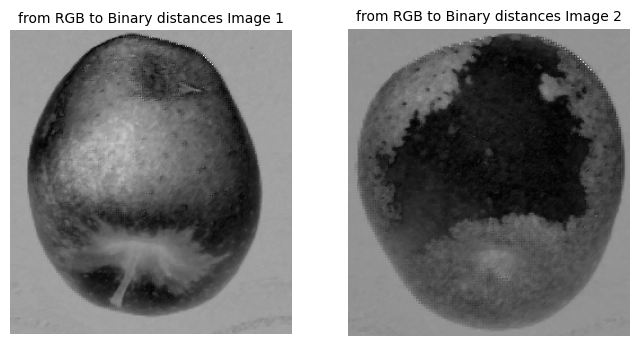

In [ ]:
plot_images(RGB_distances, title="from RGB to Binary distances Image", cmap='gray', figsize=(8,8))

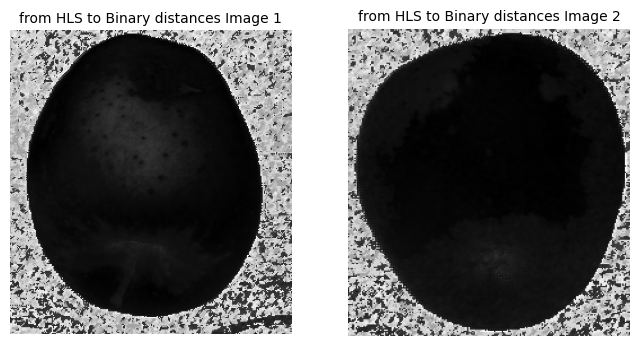

In [ ]:
plot_images(HLS_distances, title="from HLS to Binary distances Image", cmap='gray', figsize=(8,8))

As we can notice, the contrast in HLS Mahanabolis distance is not so clear. To be sure, let's try some kernel sizes of adaptive threshold

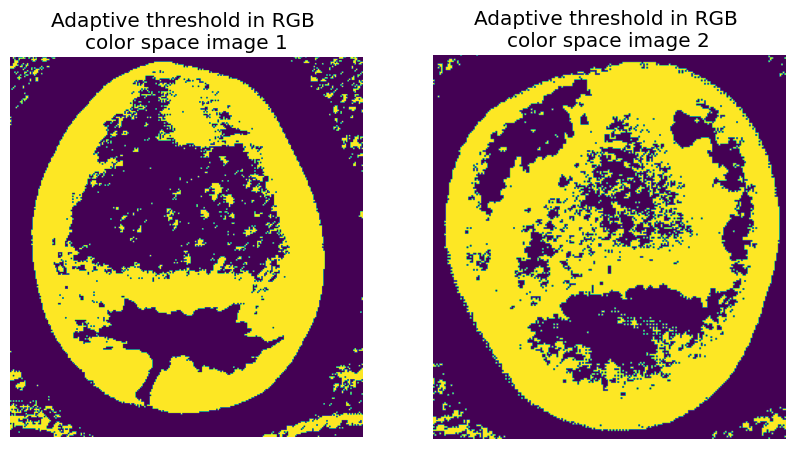

In [ ]:
reference_RGB = RGB_distances.copy()
adaptive_threshold_RGB = []

for ref in reference_RGB:
  ref = ref.astype(np.uint8)
  ref = cv.adaptiveThreshold(ref,1,cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY_INV,61,2)
  adaptive_threshold_RGB.append(ref)

plot_images(adaptive_threshold_RGB, size="x-large", title="Adaptive threshold in RGB \ncolor space image")

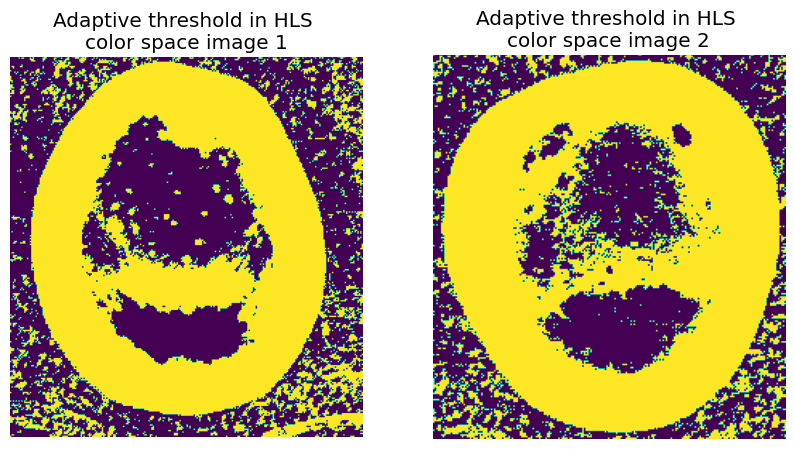

In [ ]:
reference_HLS = HLS_distances.copy()
adaptive_threshold_HLS = []

for ref in reference_HLS:
  ref = ref.astype(np.uint8)
  ref = cv.adaptiveThreshold(ref,1,cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY_INV,71,2)
  adaptive_threshold_HLS.append(ref)
  
plot_images(adaptive_threshold_HLS, size="x-large", title="Adaptive threshold in HLS \ncolor space image")

After several attempts with different neighborhood size, we tried to apply some  morphological operations in order to reduce the noise and keep only the important areas, but it did not work. In detail, the RGB channel was a bit better, with an output of the first image quite correct (only one false positive). The second image was completely wrong. Too noise disturbed the threshold binarization, and consequently the whole result was wrong. So, we agreed that neither the RGB nor HLS color spaces with Mahalanobis distance could solve our problem.

### Single-channel division

Plotting of all the color spaces defined above again, but splitting the three channels. In fact, doing this operation can enhance the contrast and reduce the complexity

In [ ]:
images = []

# all_images restoring, because before we removed the channels we ignored
color_spaces = {"RGB": cv.COLOR_BGR2RGB,
                "HSV": cv.COLOR_BGR2HSV,
                "HLS": cv.COLOR_BGR2HLS,
                "LUV": cv.COLOR_BGR2Luv}

edited_colored_images = {0: color_images[0], 1: color_images[1]}

all_images = []

for index, image in edited_colored_images.items():
  converted_images = [cv.cvtColor(image, single_color_space) for single_color_space in color_spaces.values()]

  all_images.append(converted_images)


color_space_images = {}
# Loop everything again, but separating the channels
for index, img in enumerate(all_images):
  
  for col_sp in img:
    single_color_image = []
    for color in range(3):
      single_color_image.append(col_sp[:, :, color])
    images.append(single_color_image)

  color_space_images["RGB{}".format(index+1)] = images[0]
  color_space_images["HSV{}".format(index+1)] = images[1]
  color_space_images["HLS{}".format(index+1)] = images[2]
  color_space_images["LUV{}".format(index+1)] = images[3]
  images = []

Let's print the RGB color space of the two images in grayscale format, in order to enhance more the contrast

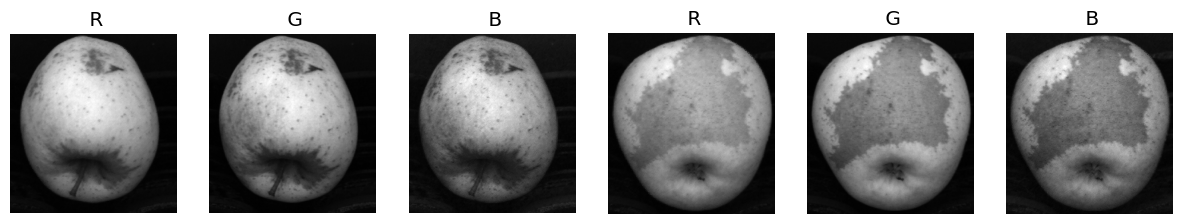

In [ ]:
plot_images(list(color_space_images['RGB1']) + list(color_space_images['RGB2']), cmap='gray' , size="x-large", custom_title=list('RGBRGB'),figsize=(15,15))

Let's print the HSV color space of the first image in grayscale format, in order to enhance more the contrast

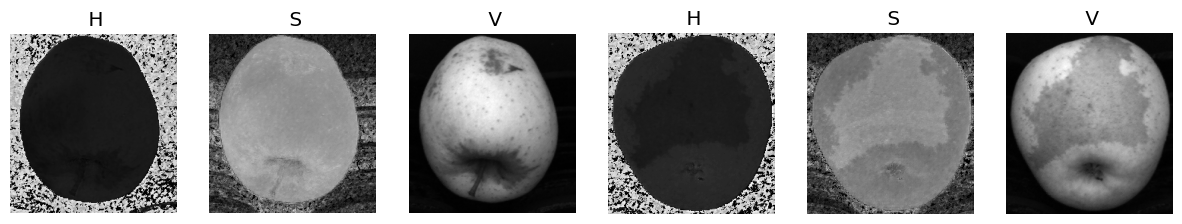

In [ ]:
plot_images(list(color_space_images['HSV1']) + list(color_space_images['HSV2']), cmap='gray', size="x-large", custom_title=list('HSVHSV'),figsize=(15,15))

Let's print the HLS color space of the first image in grayscale format, in order to enhance more the contrast

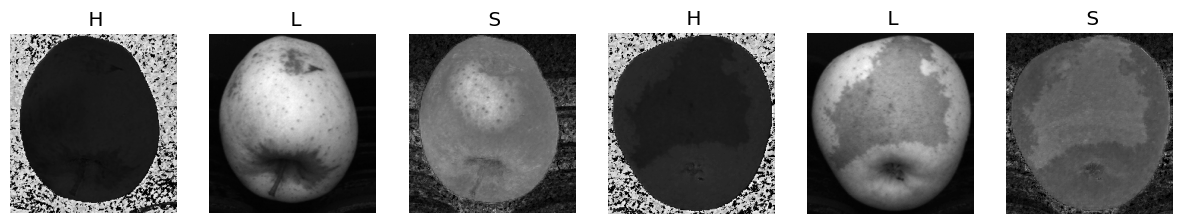

In [ ]:
plot_images(list(color_space_images['HLS1']) + list(color_space_images['HLS2']), size="x-large", cmap='gray', custom_title=list('HLSHLS'),figsize=(15,15))

Let's print the LUV color space of the first image in grayscale format, in order to enhance more the contrast

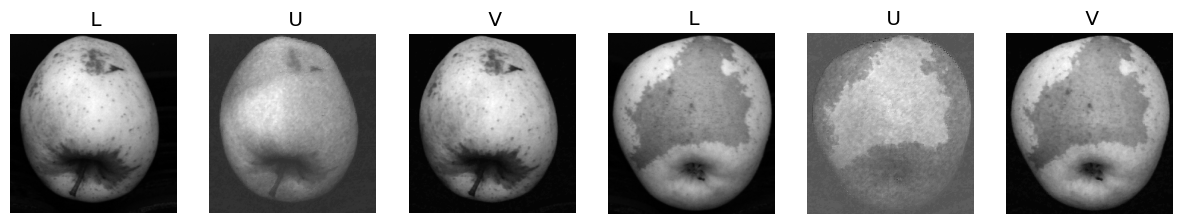

In [ ]:
plot_images(list(color_space_images['LUV1']) + list(color_space_images['LUV2']), size="x-large", cmap='gray', custom_title=list('LUVLUV'),figsize=(15,15))

Best results were obtained with channel L from LUV. Using the adaptive threshol because of the non-uniform light distribution

### Preprocessing operations

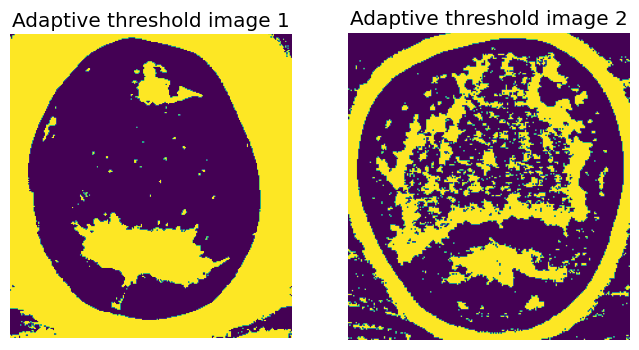

In [ ]:
# neighnorhood window needed for each image
NEIGHBORHOOD_IMAGE = (111, 25)
adaptive_thresholds = []
references = []

# L channel extraction for image 1
references.append(list(color_space_images['LUV1'])[0])
references.append(list(color_space_images['LUV2'])[0])

# threshold application
for img, neighborhood in zip(references, NEIGHBORHOOD_IMAGE):
  th = cv.adaptiveThreshold(img,1,cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY_INV,neighborhood,2)
  adaptive_thresholds.append(th)

plot_images(adaptive_thresholds, size="x-large", title="Adaptive threshold image", figsize=(8,8))

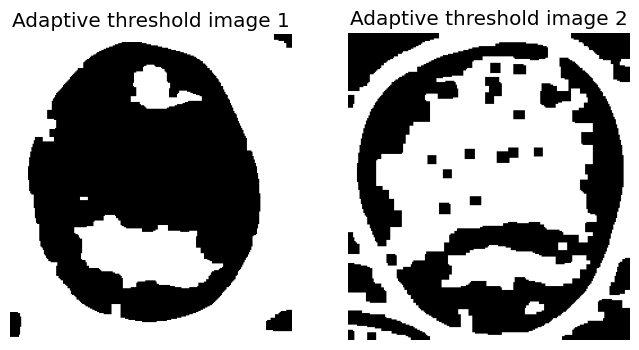

In [ ]:
kernel = np.ones((5,7),np.uint8)

for i in range(len(adaptive_thresholds)):
  img = cv.dilate(adaptive_thresholds[i],(5,7), iterations = 3)
  img = cv.morphologyEx(img, cv.MORPH_CLOSE, kernel, iterations=1)
  img = cv.morphologyEx(img, cv.MORPH_OPEN, kernel, iterations=1)
  img = cv.erode(img,(5,7),iterations = 2)
  adaptive_thresholds[i] = img

plot_images(adaptive_thresholds, size="x-large", cmap='gray', title="Adaptive threshold image", figsize=(8,8))

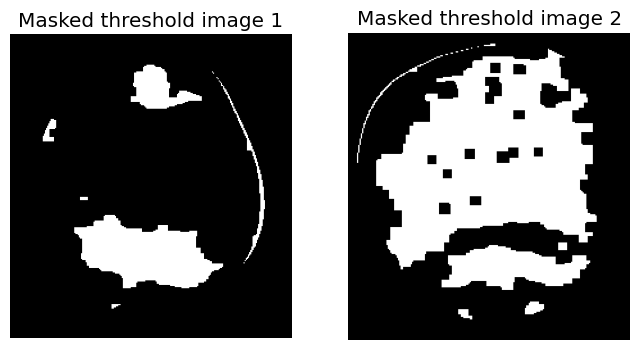

In [ ]:
# adaptation and application of the masks in order to remove the noise and the background
for i in range(len(adaptive_thresholds)):
  binary_masks[i] = cv.erode(binary_masks[i],(5,5), iterations = 5)
  adaptive_thresholds[i] *= binary_masks[i]

plot_images(adaptive_thresholds, size="x-large", cmap='gray', title="Masked threshold image", figsize=(8,8))

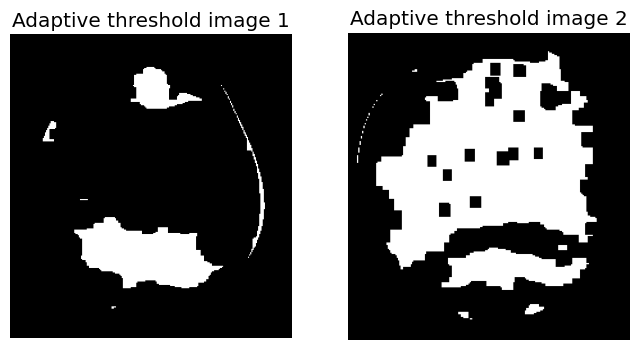

In [ ]:
for i in range(len(adaptive_thresholds)):
  img = cv.erode(adaptive_thresholds[i],(5,7),iterations = 2)
  adaptive_thresholds[i] = img

plot_images(adaptive_thresholds, size="x-large", cmap='gray', title="Adaptive threshold image", figsize=(8,8))

### contour, area and russet detection

Considering the complexity of finding common smoothing operation in order to avoid false positives, from now we are going to handle the two images separately.

In [ ]:
russet_regions = []

Russet finding in the first image

In [ ]:
# Find contours in the first binary image
contours, _ = cv.findContours(adaptive_thresholds[0], cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

# Iterate through the contours and remove small contours
min_area = 700
filtered_contours = []

for cnt in contours:
    area = cv.contourArea(cnt)
    if area > min_area:
        filtered_contours.append(cnt)


### color the russets in the original image ###

# image 1 is copied
output_image_1 = np.copy(color_images[0])

# Create a mask of zeros with the same shape as the image
mask = np.zeros_like(output_image_1)

# Fill the region enclosed by each contour with green color
for cnt in filtered_contours:
    cv.fillPoly(mask, [cnt.astype(int)], (0, 255, 0))

# Combine the mask with the original image using bitwise_and operation
result = cv.bitwise_and(output_image_1, mask)

# Add the colored contours image to the original image with a weight of 0.4 (image)
# and a weight of 0.6(russet)
output_image_1 = cv.addWeighted(output_image_1, 0.4, result, 0.6, 15)

russet_regions.append(cv.cvtColor(output_image_1, cv.COLOR_BGR2RGB))

Russet finding in the second image

In [ ]:
# Find contours in the second binary image
contours, _ = cv.findContours(adaptive_thresholds[1], cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

# Iterate through the contours and remove small contours
min_area = 3000
filtered_contours = []

for cnt in contours:
    area = cv.contourArea(cnt)
    if area > min_area:
        filtered_contours.append(cnt)


### color the russets in the original image ###

# image 2 is copied
output_image_2 = np.copy(color_images[1])

# Create a mask of zeros with the same shape as the image
mask = np.zeros_like(output_image_2)

# Fill the region enclosed by each contour with green color
for cnt in filtered_contours:
    cv.fillPoly(mask, [cnt.astype(int)], (0, 255, 0))

# Combine the mask with the original image using bitwise_and operation
result = cv.bitwise_and(output_image_2, mask)

# Add the colored contours image to the original image with a weight of 0.4 (image)
# and a weight of 0.6(russet)
output_image_2 = cv.addWeighted(output_image_2, 0.4, result, 0.6, 15)

russet_regions.append(cv.cvtColor(output_image_2, cv.COLOR_BGR2RGB))

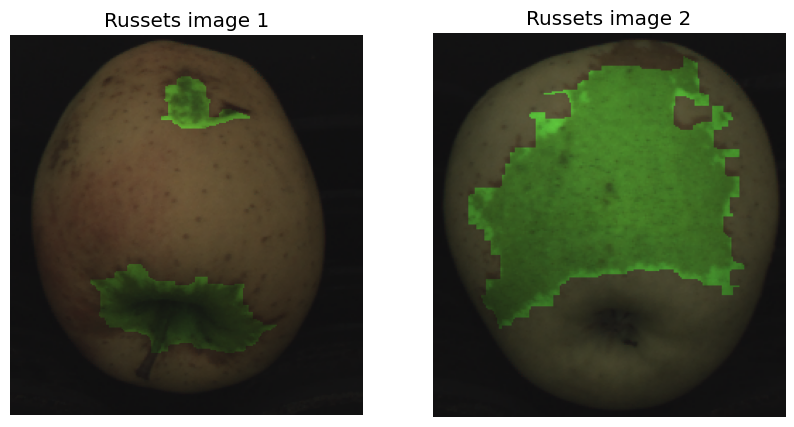

In [ ]:
plot_images(russet_regions, size="x-large", title="Russets image")

## **useful OpenCV functions used to achieve the task**:

### **cv.findContours**:
This function works thanks two approaches:
  - Contour detection: The cv.findContours function is called with the preprocessed image and the desired parameters for contour retrieval and approximation. The function first identifies the edge pixels of the objects in the image using an edge detector such as Sobel, Canny, or Laplacian. These edge pixels are then linked together to form closed contours using the contour tracing algorithm. The algorithm starts at a random edge point and follows the edge in both directions until it reaches the starting point again, forming a closed loop. This process is repeated until all the edge pixels have been assigned to a contour.

  - Contour approximation: The contours found in the previous step may contain a large number of points, some of which may be redundant or irrelevant for the intended application. Therefore, the cv.findContours function allows for an optional contour approximation method to reduce the number of points needed to represent each contour while preserving its shape.

the arguments of the function are:

  - image: the input binary image in which contours are to be detected.
  - mode: the contour retrieval mode;
    - cv.RETR_TREE: retrieves all the contours in the image and organizes them into a tree hierarchy based on their nesting relationships.

  - method: the contour approximation method. This parameter specifies how the contours are to be approximated:
    - cv.CHAIN_APPROX_SIMPLE: compresses horizontal, vertical, and diagonal segments and leaves only their end points.

The function returns two values:

  - contours: a list of the contours found in the image. Each contour is represented as a list of points.
  - hierarchy: a numpy array that describes the hierarchical relationships between the contours. 

### **cv.fillPoly()**:

it is a function that is used to fill the interior of a polygonal contour with a specified color. The function takes three arguments:

  - img: The image on which to draw the filled polygon. This should be a NumPy array representing an image in which the polygon is to be drawn.

  - pts: A list of NumPy arrays, where each array contains the x and y coordinates of the vertices of a polygonal contour. These contours define the region(s) to be filled.

  - color: The color with which to fill the polygon, given as a tuple or list of BGR values.

The cv.fillPoly() function works by scanning the rows of the image and filling the pixels within the polygonal contour with the specified color. 

### **cv.addWeighted()**:

it is a function used to blend two images together by adding them with different weights. The function takes five arguments:

  - src1: The first input image. This should be a NumPy array representing an image.

  - alpha: The weight of the first image. This should be a scalar value in the range \[0, 1].

  - src2: The second input image. This should be a NumPy array representing an image with the same shape as src1.
    
  - beta: The weight of the second image. This should be a scalar value in the range \[0, 1].
    
  - gamma: A scalar added to each sum. This is an optional parameter that defaults to 0.

The cv.addWeighted() function works by multiplying each pixel in the first image by alpha, and multiplying each pixel in the second image by beta. The two resulting images are then added together, and the gamma value is added to each sum. The resulting image is returned as a NumPy array.


## Made by 
  - Luca Reggiani
  - Simone Vizzuso